# Quick visualisations of the data

<b>First we should pip sinatll the below modules if we have't already </b>

In [1]:
#!pip install wordcloud
#!pip install google-cloud-storage
#!pip install gcsfs
#!pip install wordsegment

<b>Importing dependencies </b>

In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import os
import pandas as pd
import re
import json
import html
import wordsegment as ws
from wordsegment import load, segment
import seaborn as sns

<b> Testing if we have GCS bucket access... </b>

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= "./storageCreds.json"
from google.cloud import storage
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
print(buckets) # Testing if access to GCS has been granted

pd.set_option('display.max_colwidth', -1) # Set col width to -1 so we can see entire text column

[<Bucket: csc3002>]


<b> Loading in training data for HatEval </b>

In [3]:
train = pd.read_csv('gs://csc3002/hateval2019/hateval2019_en_train.csv', sep=',',  index_col = False, encoding = 'utf-8')
dev =  pd.read_csv('gs://csc3002/hateval2019/hateval2019_en_dev.csv', sep=',',  index_col = False, encoding = 'utf-8')
frames = [train,dev]
data = pd.concat(frames)
data.rename(columns={'text': 'tweet', 'HS': 'label'}, inplace=True)
cols = ['TR', 'AG']
data.drop(cols, inplace = True, axis = 1)

data.loc[data['label'] == 0, 'label'] = "Not Hate"
data.loc[data['label'] == 1, 'label'] = "Hate"
data.head()

id  \
0  201   
1  202   
2  203   
3  204   
4  205   

                                                                                                                                                                                                                                                                                                          tweet  \
0  Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike                                                                                                                                                                                      
1  Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn   
2  @KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe                                                
3  NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6                                                                                                                                                                                 
4  Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX                                                                                                                                                                                     

      label  
0  Hate      
1  Hate      
2  Hate      
3  Not Hate  
4  Not Hate

<b> Text Pre-processing functions </b>

In [6]:
def preprocess(text_string):
    """
    Accepts a text string and:
    1) Removes URLS
    2) lots of whitespace with one instance
    3) Removes mentions
    4) Uses the html.unescape() method to convert unicode to text counterpart
    5) Replace & with and
    6) Remove the fact the tweet is a retweet if it is - knowing the tweet is 
       a retweet does not help towards our classification task.
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[#$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+:'
    mention_regex1 = '@[\w\-]+'
    RT_regex = '(RT|rt)[ ]*@[ ]*[\S]+'
    
    # Replaces urls with URL
    parsed_text = re.sub(giant_url_regex, '', text_string)
    parsed_text = re.sub('URL', '', parsed_text)
    
    # Remove the fact the tweet is a retweet. 
    # (we're only interested in the language of the tweet here)
    parsed_text = re.sub(RT_regex, ' ', parsed_text) 
    
    # Removes mentions as they're redundant information
    parsed_text = re.sub(mention_regex, '',  parsed_text)
    #including mentions with colons after - this seems to come up often
    parsed_text = re.sub(mention_regex1, '',  parsed_text)  

    #Replace &amp; with and
    parsed_text = re.sub('&amp;', 'and', parsed_text)

    # Remove unicode
    parsed_text = re.sub(r'[^\x00-\x7F]','', parsed_text) 
    parsed_text = re.sub(r'&#[0-9]+;', '', parsed_text)  

    # Convert unicode missed by above regex to text
    parsed_text = html.unescape(parsed_text)
    
    # Remove excess whitespace at the end
    parsed_text = re.sub(space_pattern, ' ', parsed_text) 
    
    # Set text to lowercase and strip
    parsed_text = parsed_text.lower()
    parsed_text = parsed_text.strip()
    
    return parsed_text

load()
#The values below of the bigrams reflect the amount of search results on google that come up
ws.BIGRAMS['alt right'] = 1.17e8 # update wordsegment dict so 
                                #it recognises altright as "alt right" rather than salt right
ws.BIGRAMS['white supremacists'] = 3.86e6
ws.BIGRAMS['tweets'] = 6.26e10
ws.BIGRAMS['independece day'] = 6.21e7

def hashtagSegment(text_string):
    
    #We target hashtags so that we only segment the hashtag strings.
    #Otherwise the segment function may operate on misspelled words also; which
    #often appear in hate speech tweets owing to the ill education of those spewing it
    temp_str = []
    for word in text_string.split(' '):
        if word.startswith('#') == False:
            temp_str.append(word)
        else:
            temp_str = temp_str + segment(word)
            
    text_string = ' '.join(temp_str)       
    return text_string


data['tweet'] = data['tweet'].apply(preprocess)
data['tweet'] = data['tweet'].apply(hashtagSegment)


<b> Simple functions that perform quick visualisations of the data. We can either plot a bar chart side by side for a binary comparison of hate speech vs non hate speech in the dataset in terms of numbers.

We also have a word cloud function which tells us the most common terms in the data</b>

In [38]:
def plot_data(df, class_name):
    color = ['cornflowerblue', 'lightcoral']
    ax = df[class_name].value_counts().plot(kind='bar',
                                                    figsize=(12, 8), color = color)
    ax.set_title("Class Distribution").set_fontsize(20)
    ax.set_ylabel('Amount of tweets', fontsize = 12)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                
                
                tick.label.set_rotation('horizontal')
    total = 0
    for p in ax.patches:
        total += p.get_height()
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(), decimals=2), (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                    bbox=dict(facecolor='yellow', alpha=0.5))

        ax.annotate(str(np.round(p.get_height() / total * 100, decimals=2)) + "%",
                    (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                    ha='center', va='center', xytext=(0, -20), textcoords='offset points',
                    bbox=dict(facecolor='gray', alpha=0.5))


def plot_word_cloud(df):
    text = df.tweet.values
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


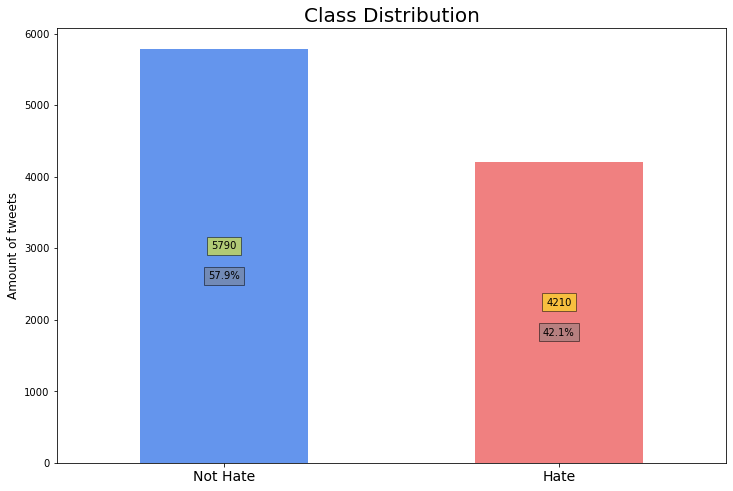

In [68]:
plot_data(data, "label")

In [37]:
NoHate = data[(data['label'] == 'Not Hate')]
Hate = data[(data['label'] == 'Hate')]

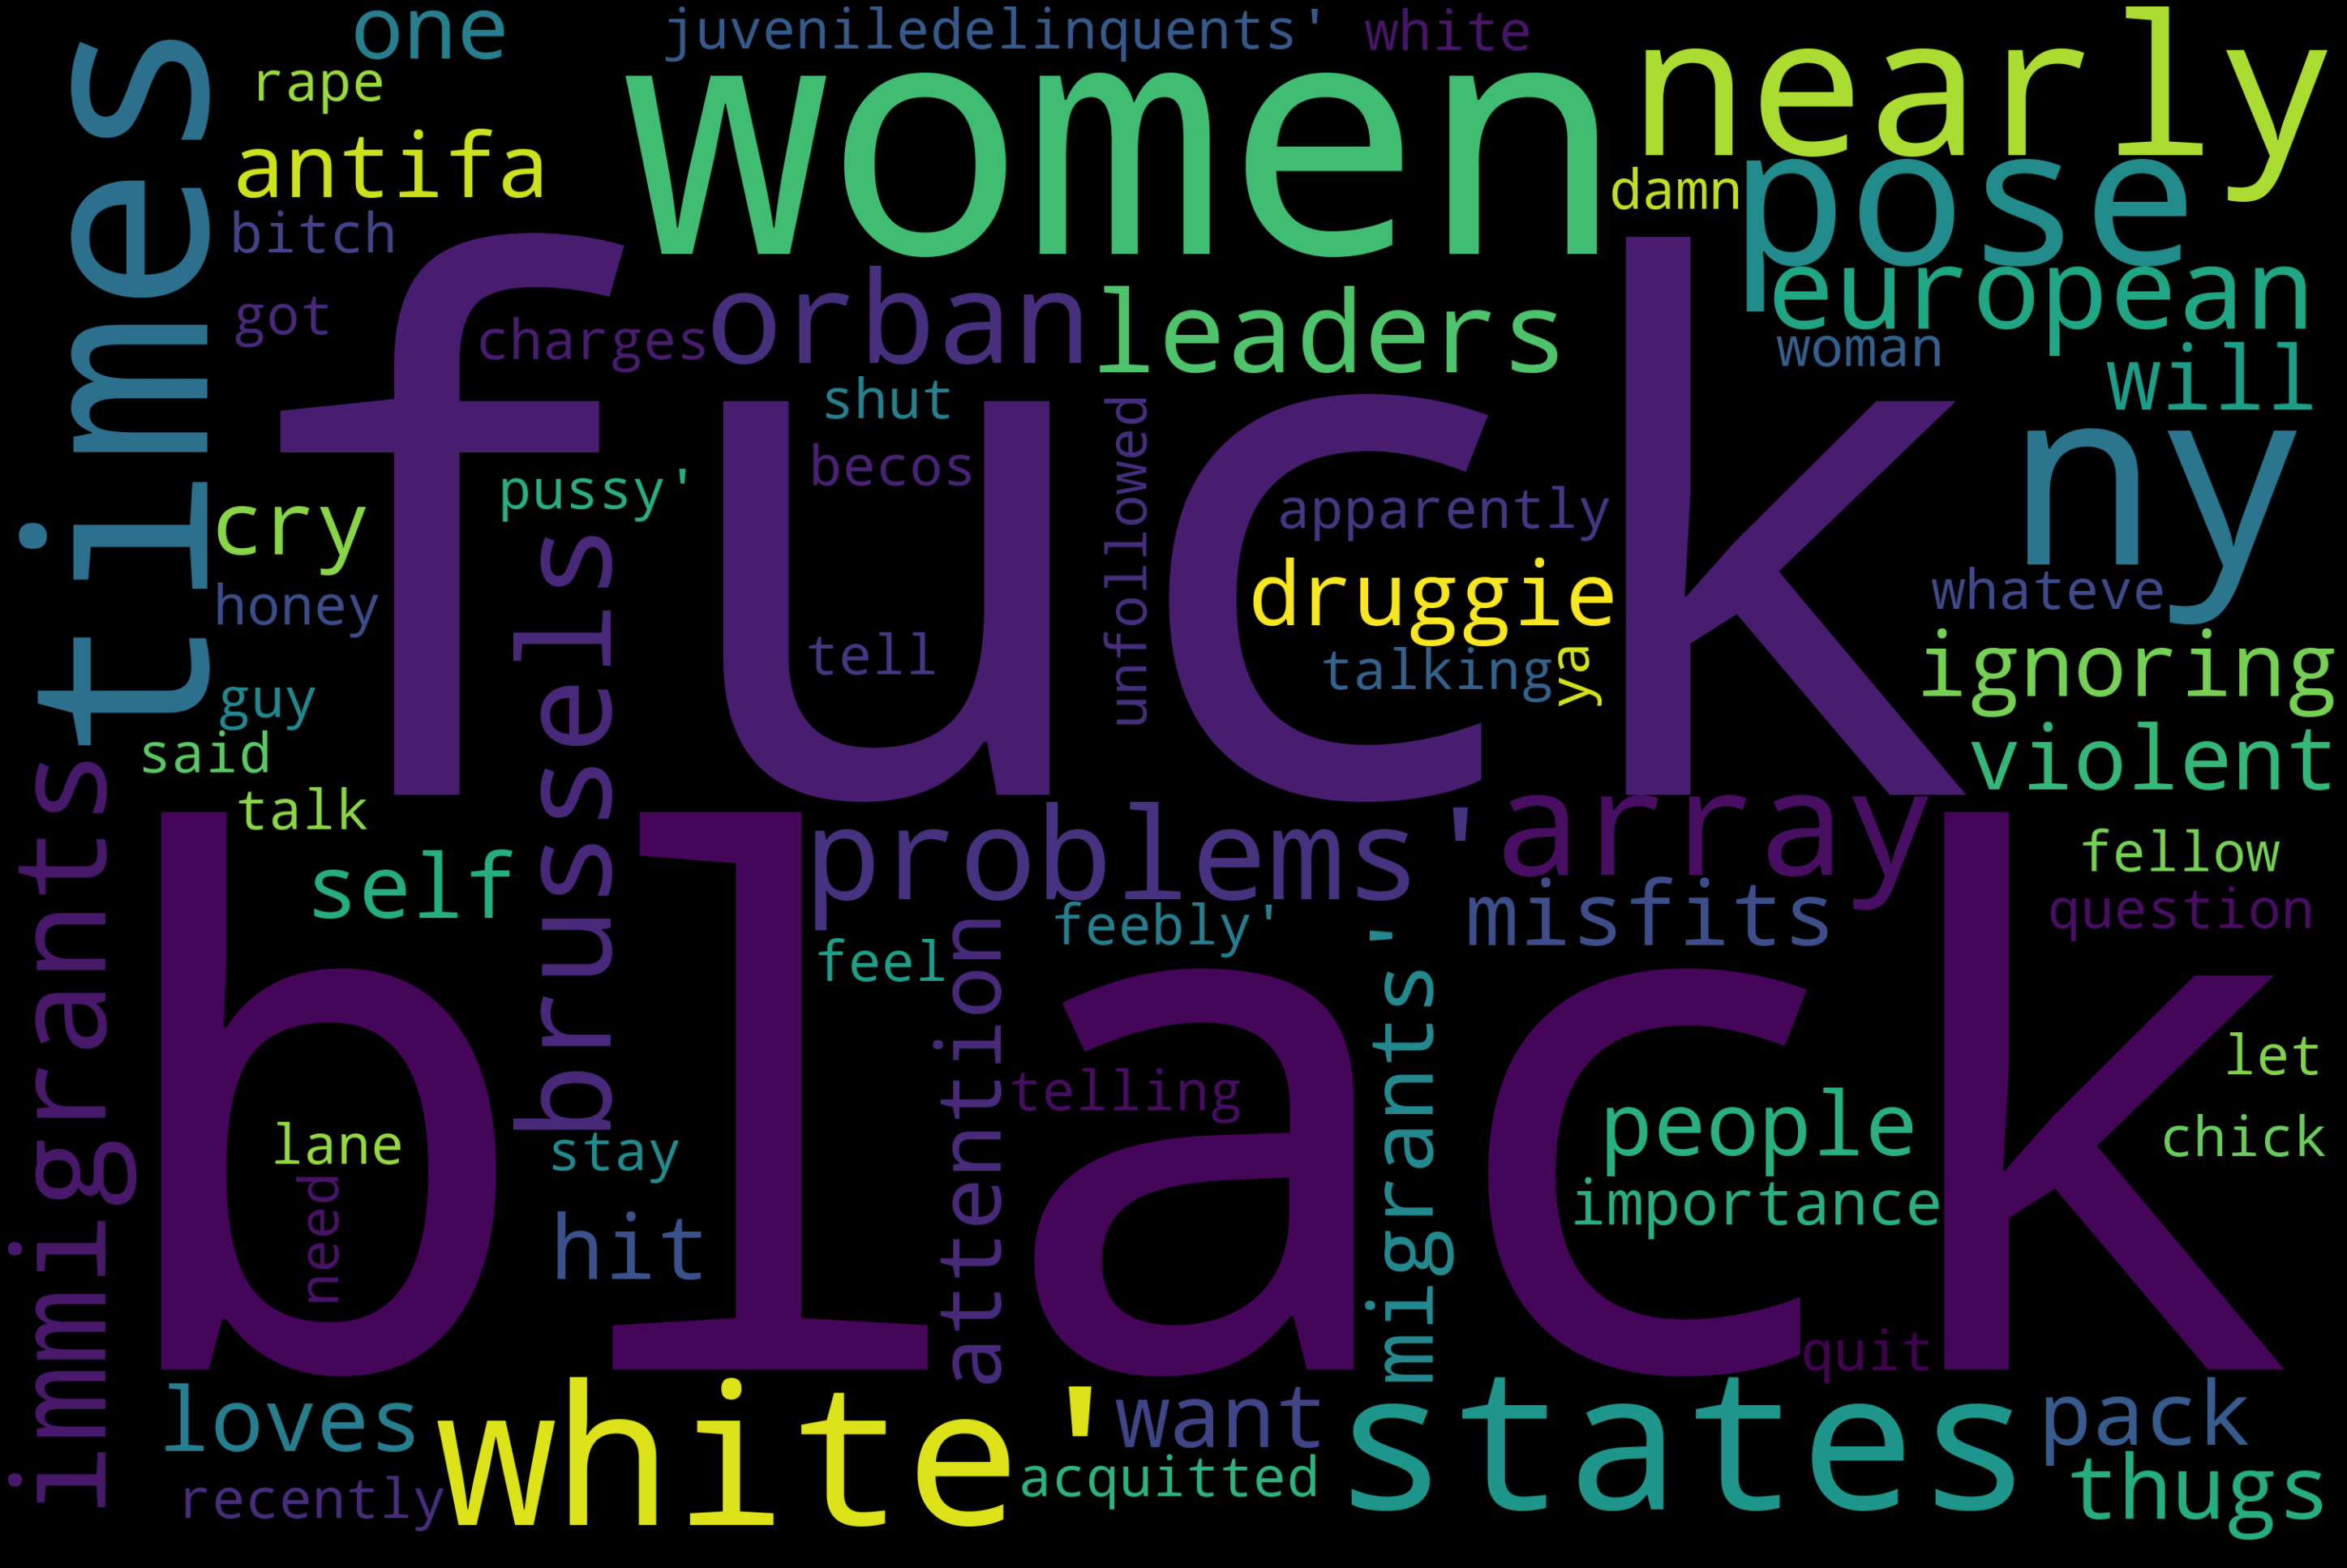

In [38]:
plot_word_cloud(NoHate)

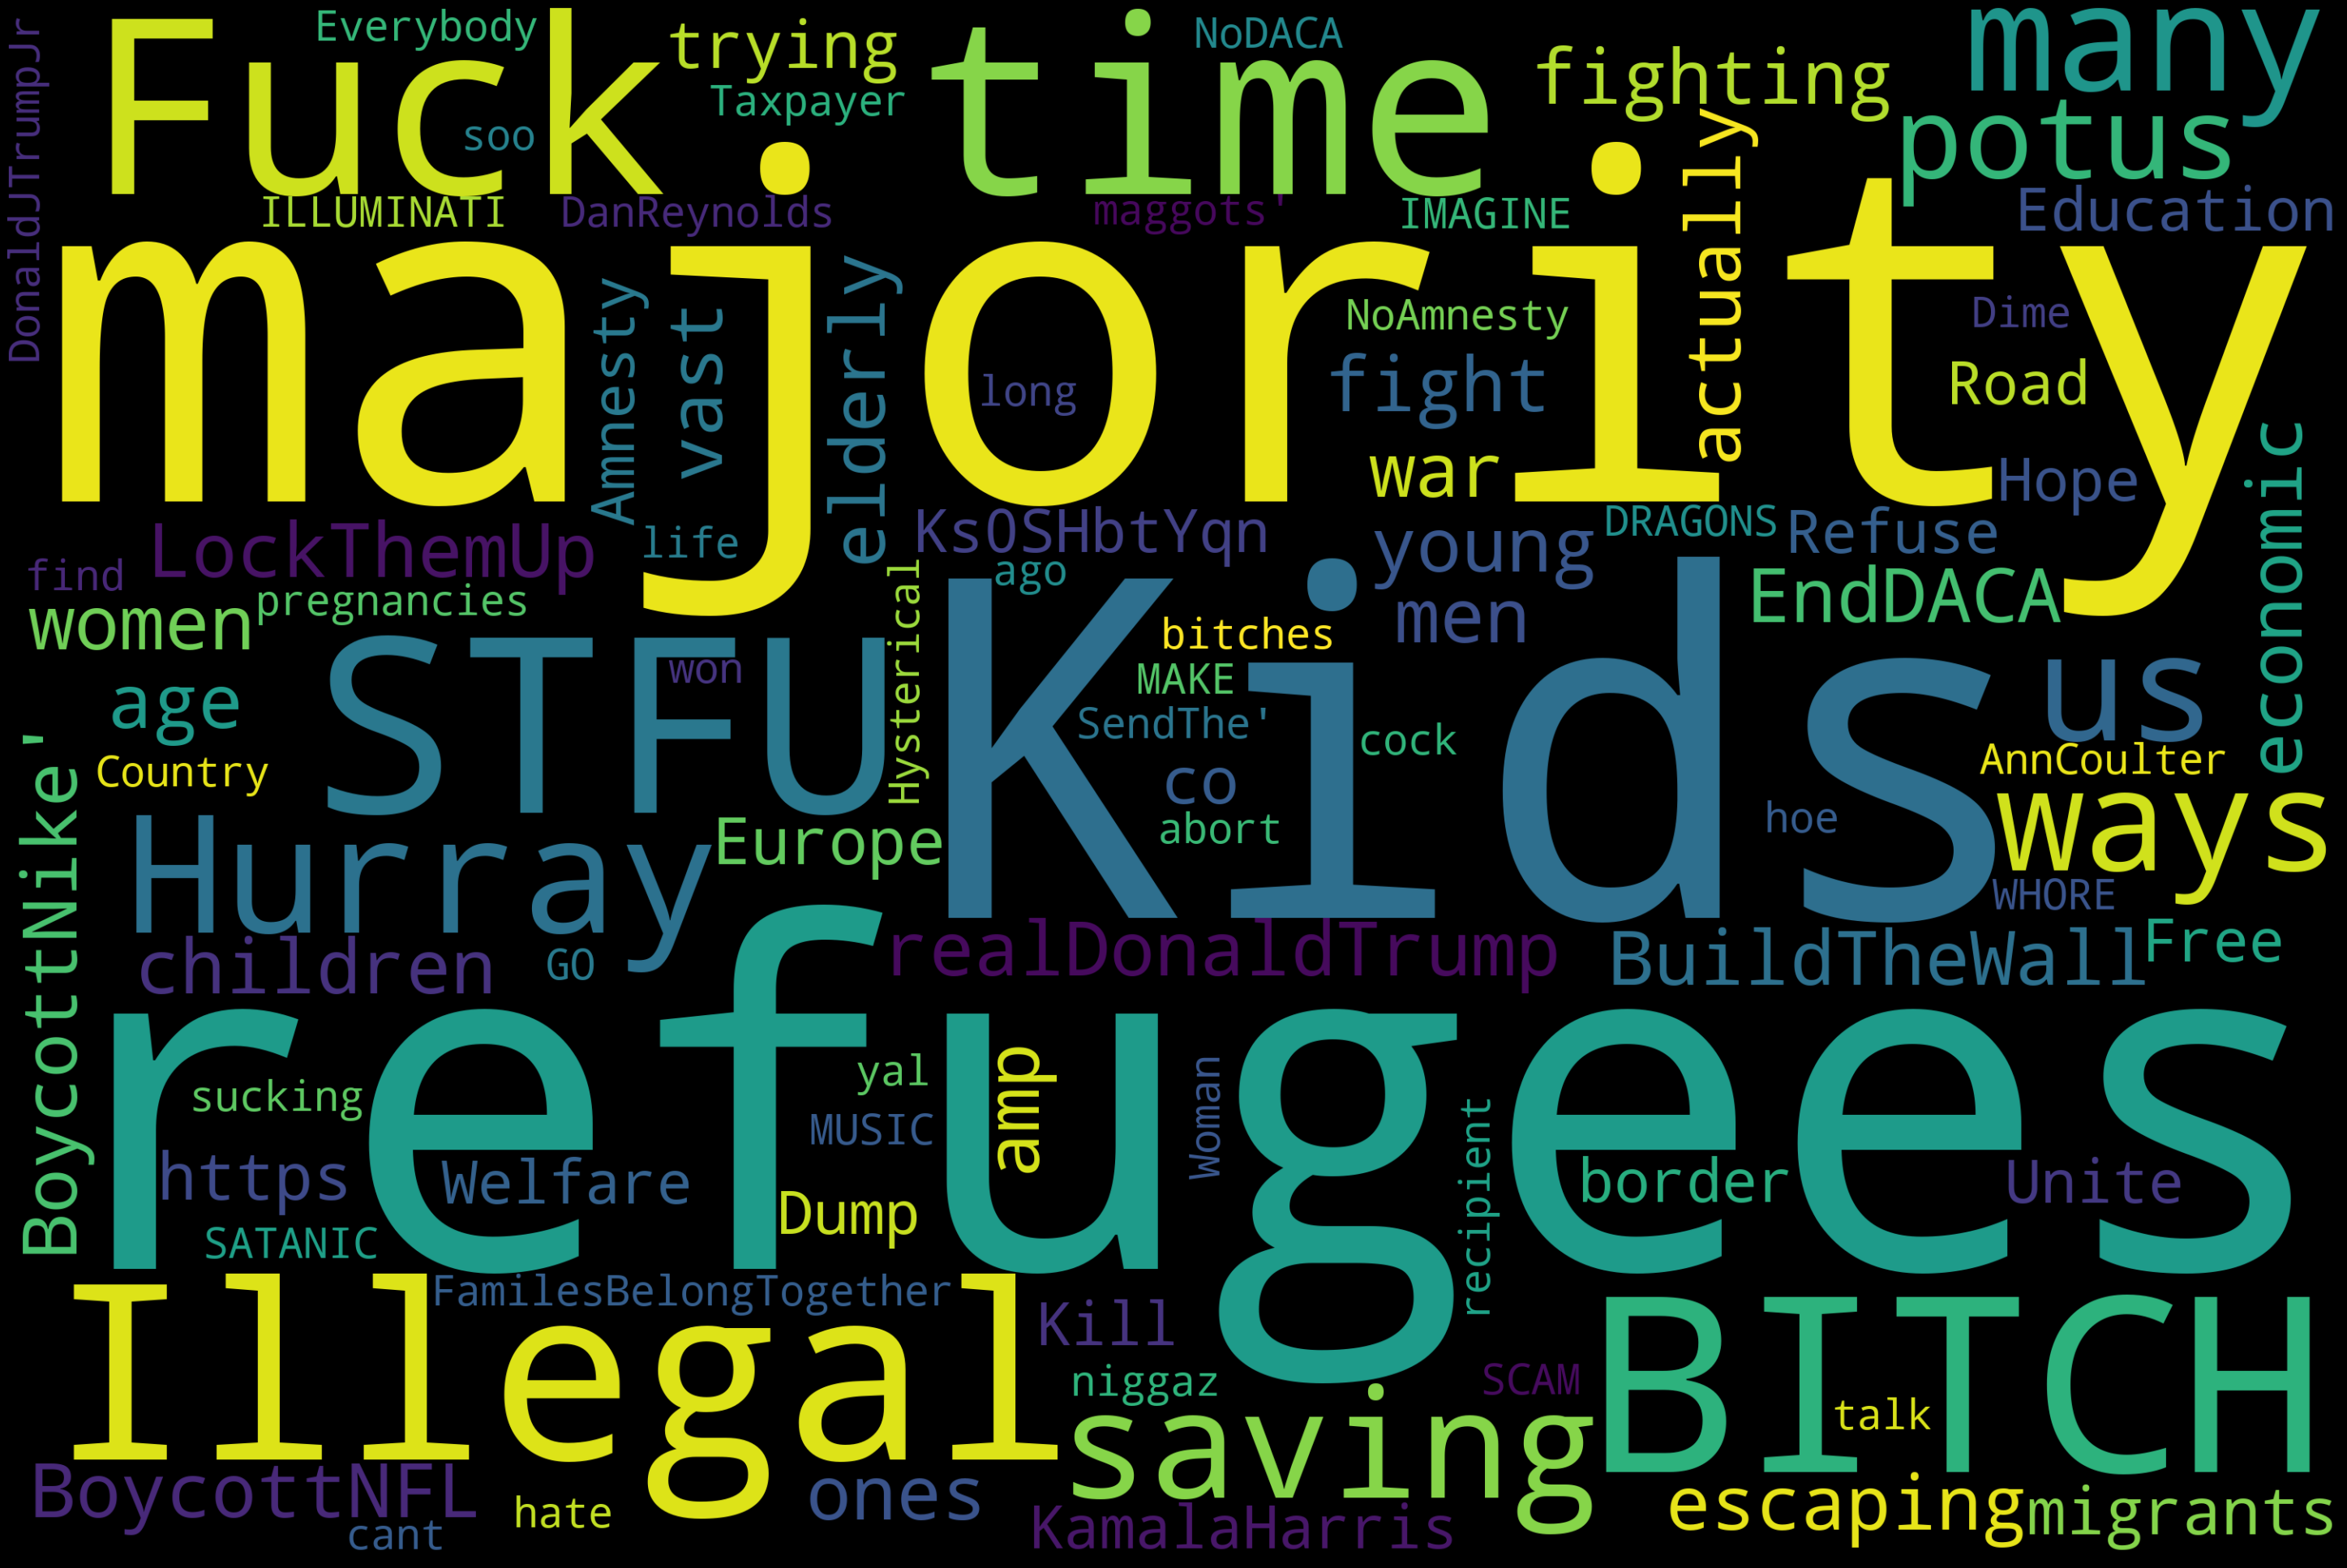

In [19]:
plot_word_cloud(Hate)

<b>Loading in dataset comparing different methods of text pre-processing </b>

In [3]:
preprocdat = pd.read_csv('gs://csc3002/hateval2019/preprocess_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
preprocdat.dropna(inplace = True)
preprocdat.Accuracy = preprocdat.Accuracy * 100
preprocdat

Accuracy  F1 Score  False Negatives  False Positives  \
Basic                 76.370000  0.727456  48.530000        45.990000         
ReplaceEmoji          77.903333  0.740020  42.263333        46.123333         
ReplaceEmoji_v2       77.625000  0.741741  43.920000        45.580000         
Hashtag Segmentation  78.252500  0.746762  39.500000        47.490000         
Remove Punctuation    77.550000  0.735776  42.700000        47.100000         
Lemmatize Text        76.538333  0.725722  45.460000        48.386667         
Remove Stopwords      74.083333  0.692779  51.027778        52.638889         

                      Precision    Recall              Training Time  \
Basic                 0.711958   0.711770  0 days 00:06:02.896088370   
ReplaceEmoji          0.733583   0.748993  0 days 00:05:32.472314      
ReplaceEmoji_v2       0.742242   0.739116  0 days 00:05:31.309126      
Hashtag Segmentation  0.732840   0.765444  0 days 00:05:59.213520      
Remove Punctuation    0.731632   0.746545  0 days 00:05:54.590594      
Lemmatize Text        0.719198   0.730200  0 days 00:05:26.026977      
Remove Stopwords      0.699014   0.697092  0.003977828                 

                      True Negatives  True Positives       auc  
Basic                 185.600000      119.880000      0.756590  
ReplaceEmoji          185.480000      126.133333      0.774917  
ReplaceEmoji_v2       186.030000      124.470000      0.771154  
Hashtag Segmentation  184.100000      128.910000      0.780197  
Remove Punctuation    184.460000      125.740000      0.771590  
Lemmatize Text        183.086667      123.066667      0.760576  
Remove Stopwords      178.916667      117.416667      0.734862

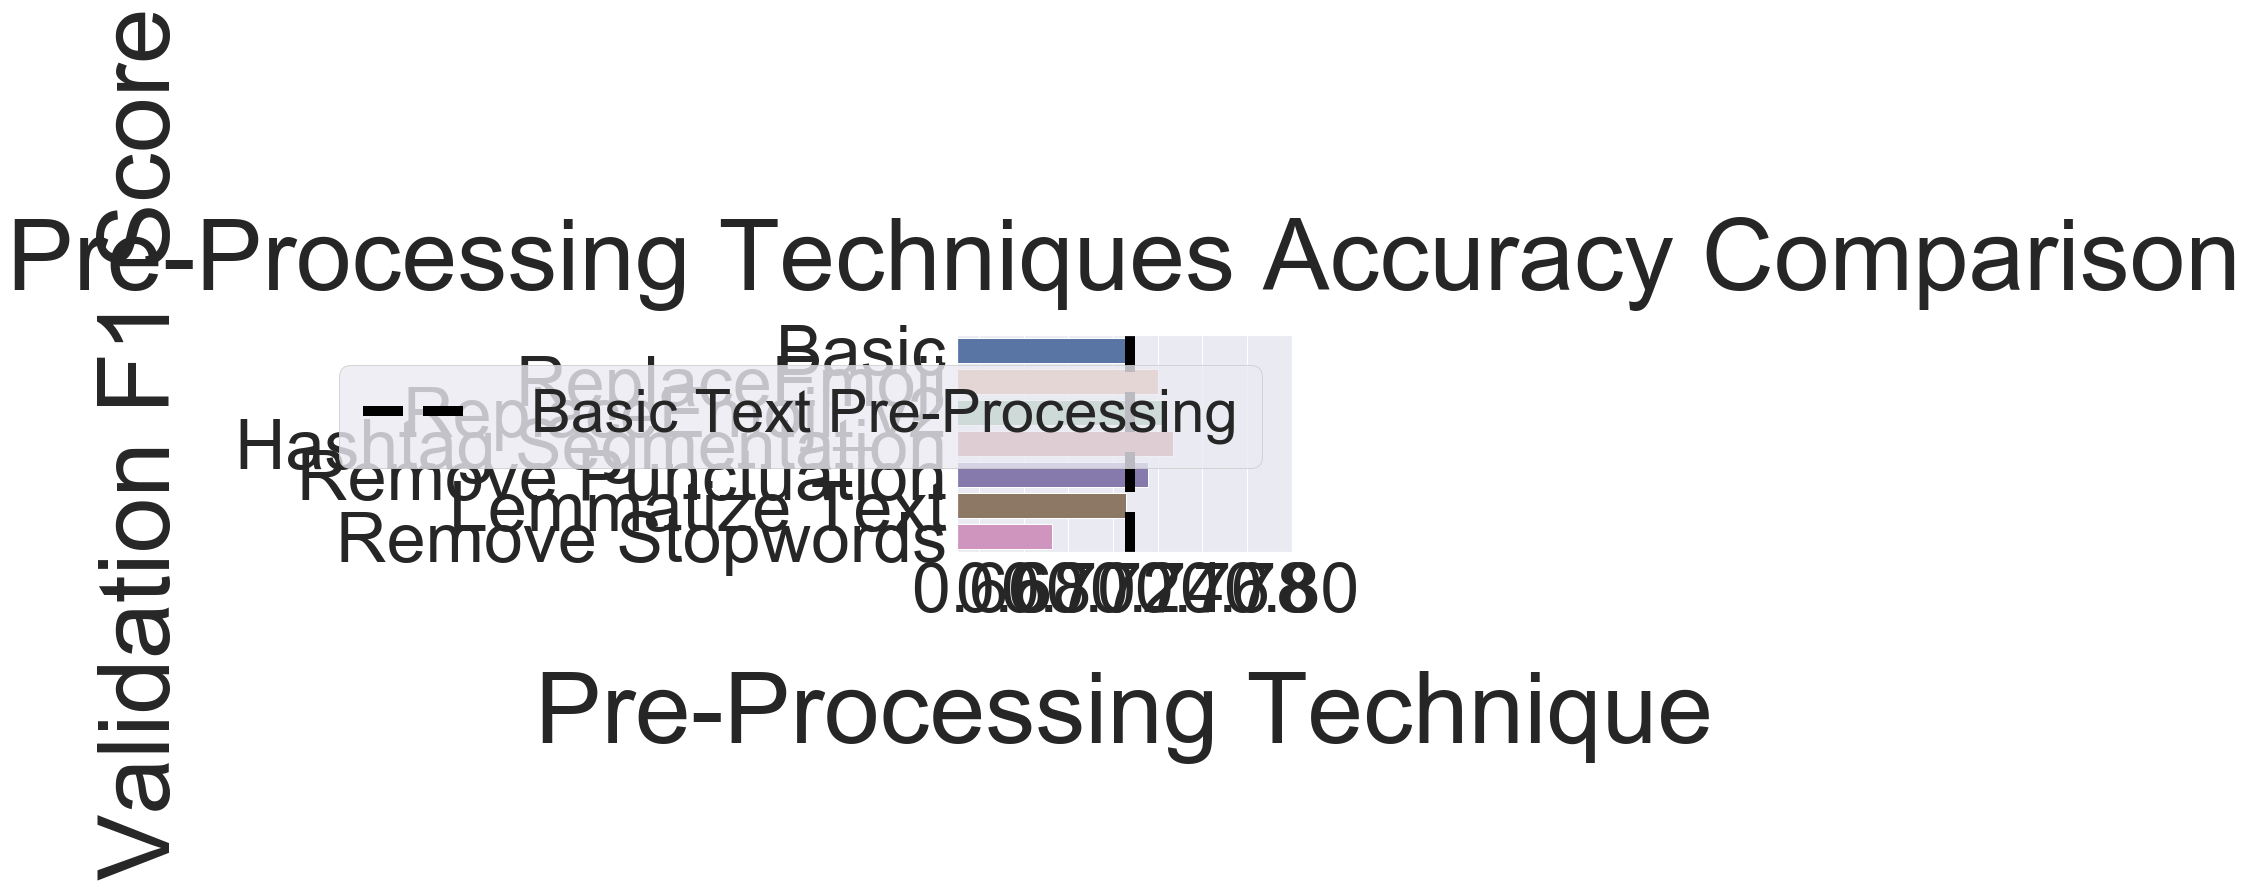

In [4]:
sns.set(style = "darkgrid")
ax = sns.barplot(y = preprocdat.index, x ="F1 Score",\
                  data = preprocdat)
plt.title("Pre-Processing Techniques Accuracy Comparison", \
          fontsize = 100, pad =45 )

plt.ylabel("Validation F1 Score", fontsize = 100, labelpad =45)
plt.xlabel("Pre-Processing Technique", fontsize = 100, labelpad =45)
plt.xticks(fontsize = 70)
plt.yticks(fontsize = 70)
plt.xlim(0.65, 0.8)
plt.rcParams["figure.figsize"] = (60,30)

threshold = preprocdat.loc['Basic']['F1 Score']
ax.axvline(threshold, 0,1, label='Basic Text Pre-Processing', color = "black",\
            linestyle = "--", lw = 10.0, dashes = [4,2])
ax.legend(prop = {'size': 60})

<b>Loading in dataset comparing different steps of further pre-training. The first dataset was further pre-trained with a learning rate of 5e-5. The other was further-pretrained with a learning rate of 2e-5</b>

In [5]:
pretraindat = pd.read_csv('gs://csc3002/hateval2019/pretraining_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
pretraindat.index = (pretraindat.index/1000).astype(int)
pretraindat

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.763358  0.798466  0.803061  38.20            39.00             
100  0.764554  0.795330  0.798469  37.08            41.92             
80   0.767475  0.796891  0.798265  35.00            44.08             
60   0.758429  0.783174  0.788163  41.16            41.88             
40   0.748400  0.775228  0.781429  43.80            41.88             
0    0.725141  0.731132  0.748469  62.44            36.16             

     Precision    Recall              Training Time  True Negatives  \
120  0.766623   0.769235  0.004281233                187.40           
100  0.755519   0.775787  0 days 00:05:30.002256     184.60           
80   0.749522   0.788458  0 days 00:05:30.042791     182.44           
60   0.720442   0.751278  0 days 00:05:41.106568     184.64           
40   0.715475   0.735362  0 days 00:06:17.175884     184.64           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  127.40          
100  128.40          
80   130.48          
60   124.32          
40   121.68          
0    103.04

In [6]:
pretraindat1 = pd.read_csv('gs://csc3002/hateval2019/pretraining_eval_df1.csv', sep=',',  index_col = 0, encoding = 'utf-8')
pretraindat1.index = [120, 100, 80,60,40, 0]
pretraindat1.index = pretraindat1.index.astype(int)
pretraindat1

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.765190  0.795195  0.797245  36.0000          43.4800           
100  0.768301  0.798551  0.800200  35.6800          44.2400           
80   0.768081  0.799007  0.801600  36.6000          42.7600           
60   0.767117  0.797896  0.800300  36.6200          43.2600           
40   0.757157  0.789982  0.793500  39.1125          43.4875           
0    0.725141  0.731132  0.748469  62.4400          36.1600           

     Precision    Recall              Training Time  True Negatives  \
120  0.750553   0.782374  0 days 00:05:34.251366640  183.04           
100  0.751556   0.788115  0 days 00:06:09.480712     187.36           
80   0.756257   0.782642  0 days 00:05:50.962482     188.84           
60   0.754029   0.782588  0 days 00:05:39.230519     188.32           
40   0.749598   0.767707  0.003935796                188.15           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  129.48          
100  132.72          
80   131.80          
60   131.80          
40   129.25          
0    103.04

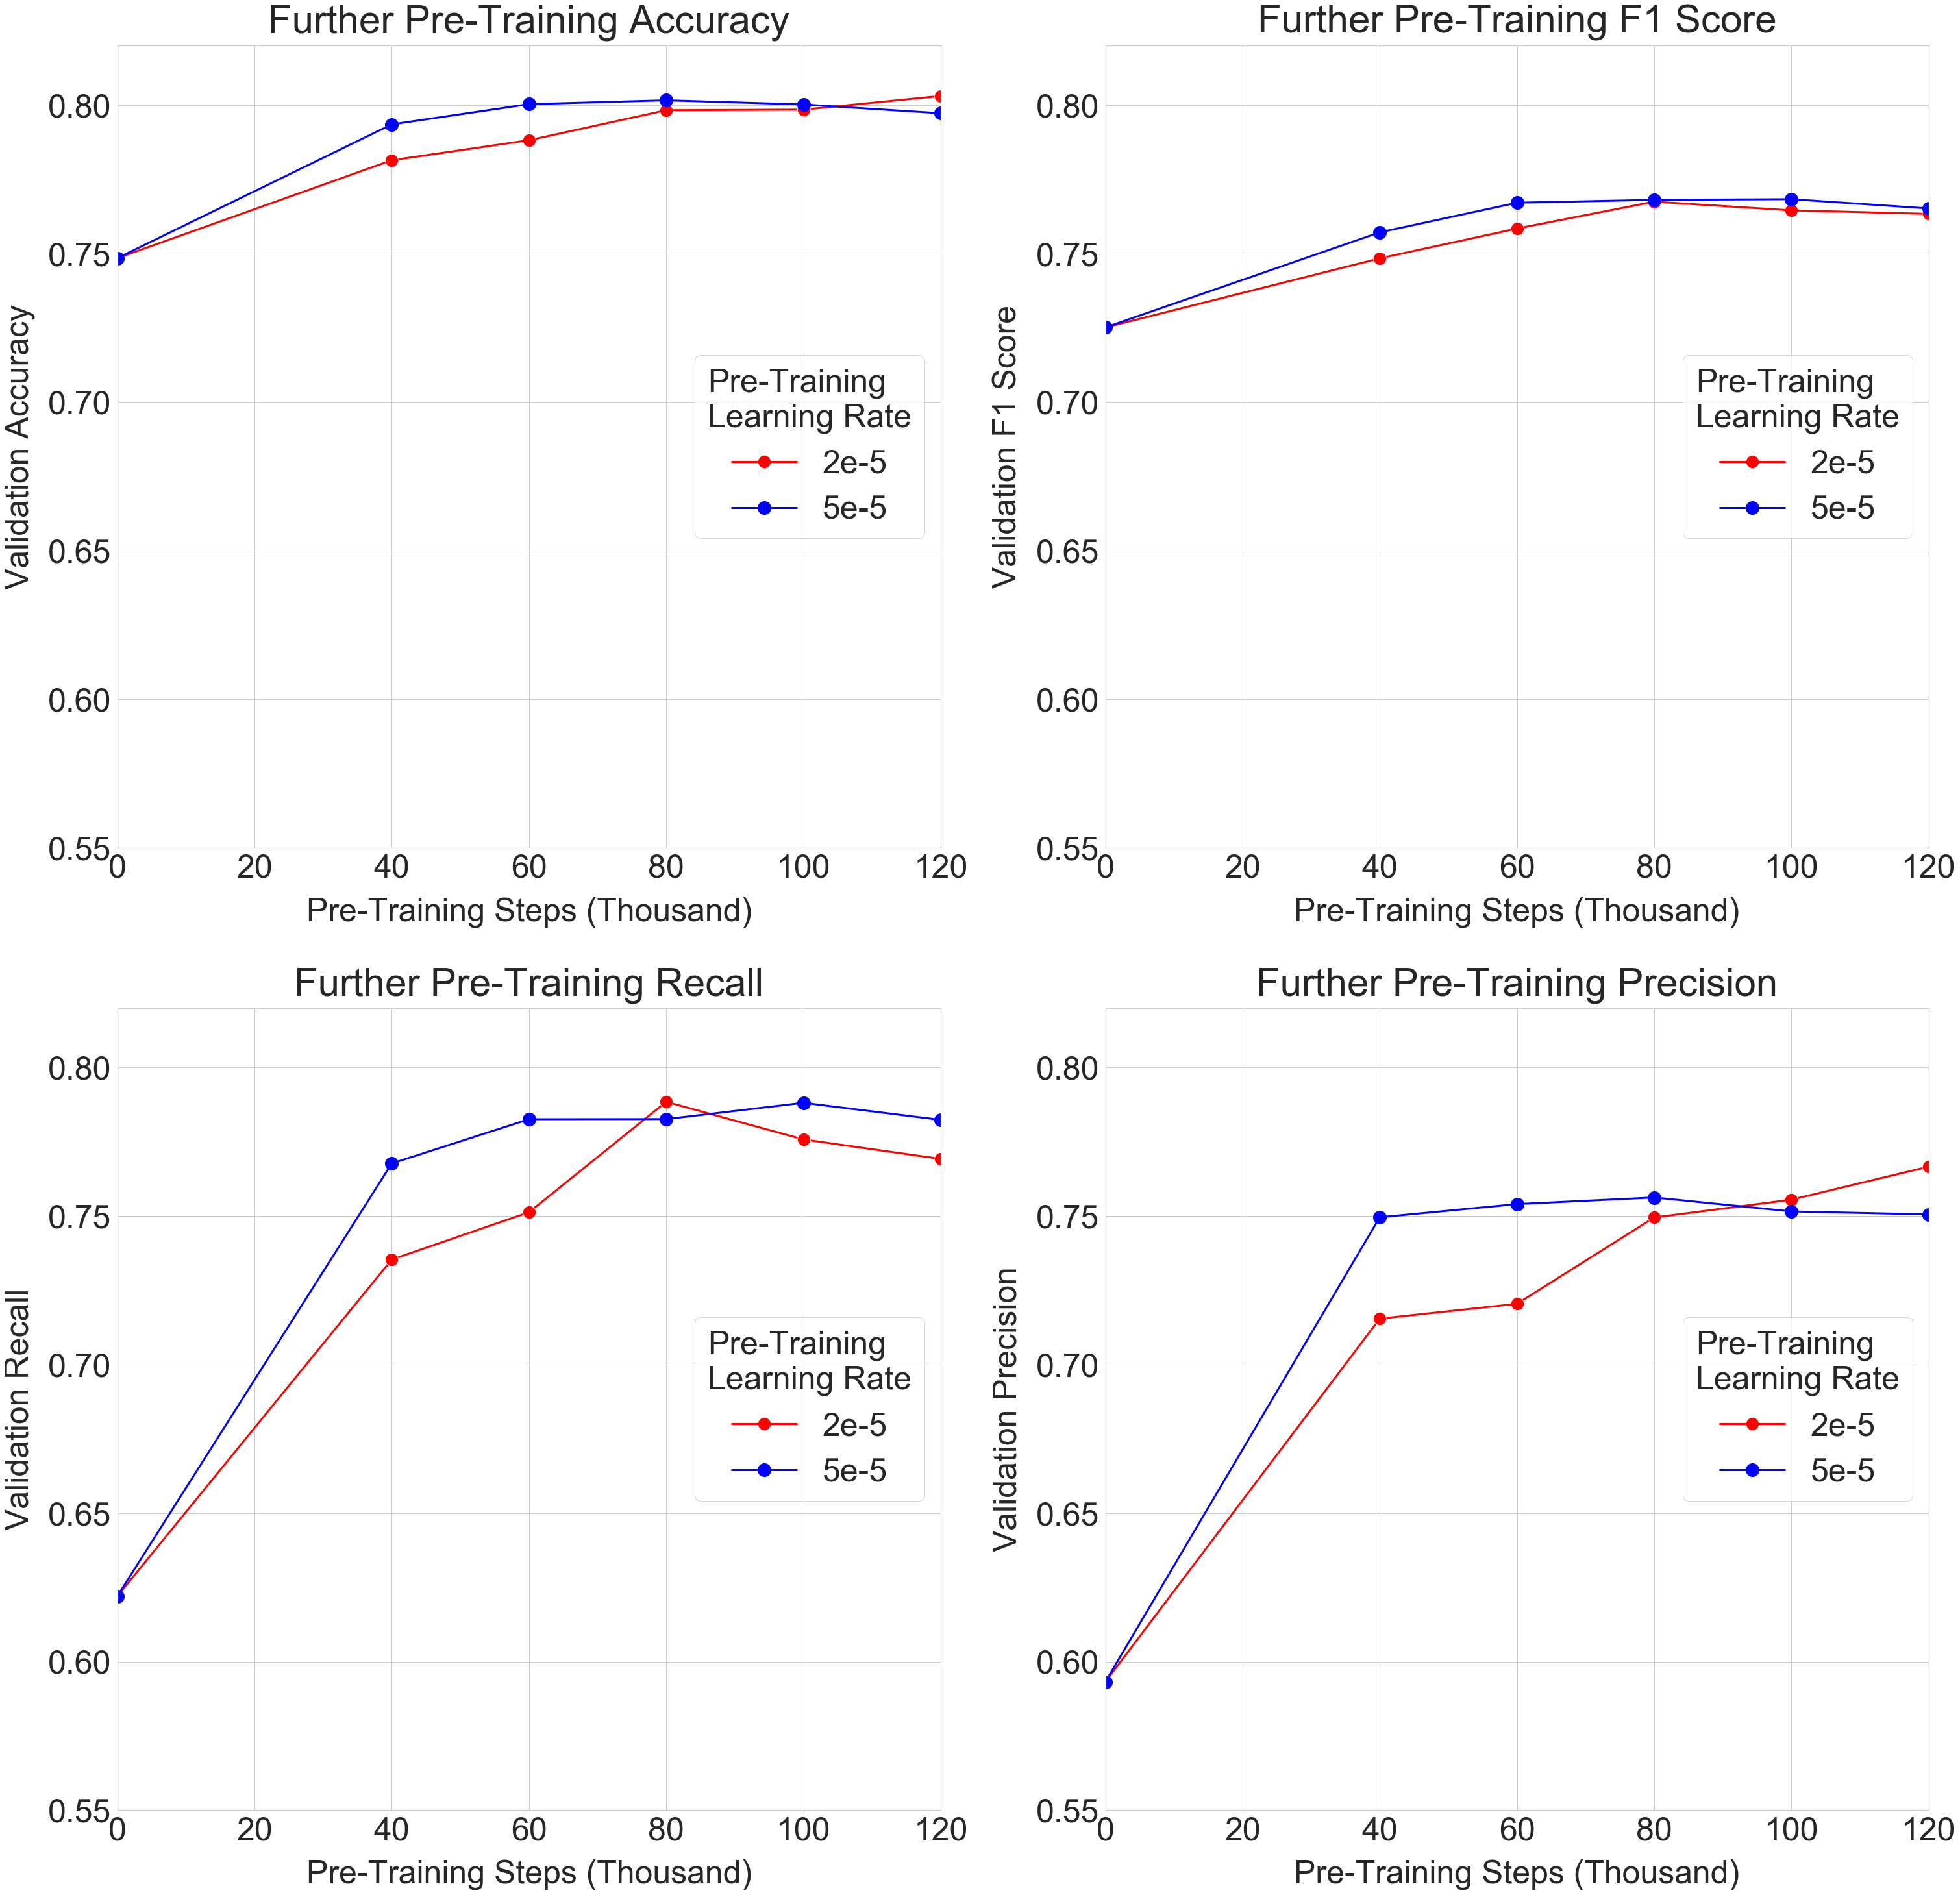

In [7]:
sns.set(style = 'whitegrid', \
        rc={'figure.figsize':(50,50), "lines.linewidth": 3, \
            'lines.markersize': 20, 'xtick.labelsize': 50, 'ytick.labelsize': 50,\
           'axes.titlesize': 60, 'axes.labelsize': 50, 'axes.labelpad': 20,\
           'legend.title_fontsize': 50, 'legend.loc': 'center right', \
            'legend.fontsize': 'large'})

padsize = 20
metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = pretraindat.index, y = metrics[i-1],\
                      data = pretraindat, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    ax.set_ylim(0.55, 0.82)
    ax.set_xlim(0, 130)
    pretraindat1[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['2e-5', '5e-5'], title = 'Pre-Training\nLearning Rate', \
              prop = {'size': 50})

plt.show()

In [12]:
noRemTerms = pd.read_csv('gs://csc3002/hateval2019/noRemTerms_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
noRemTerms.index = [120, 100, 80,60]#,40, 0]
noRemTerms.index = noRemTerms.index.astype(int)
noRemTerms

Accuracy  F1 Score  False Negatives  False Positives  Precision  \
120  0.806225  0.771988  36.62            40.89            0.764466    
100  0.808800  0.775150  36.16            40.32            0.767534    
80   0.806625  0.784265  36.95            40.40            0.766138    
60   0.808550  0.775507  35.92            40.66            0.766980    

       Recall           Training Time  True Negatives  True Positives  \
120  0.782570  0 days 00:06:35.564023  190.69          131.80           
100  0.785265  0 days 00:05:37.702464  191.28          132.24           
80   0.780577  0.003896215             191.20          131.45           
60   0.786737  0 days 00:06:38.178697  190.90          132.52           

          auc  
120  0.803006  
100  0.805582  
80   0.803073  
60   0.805577

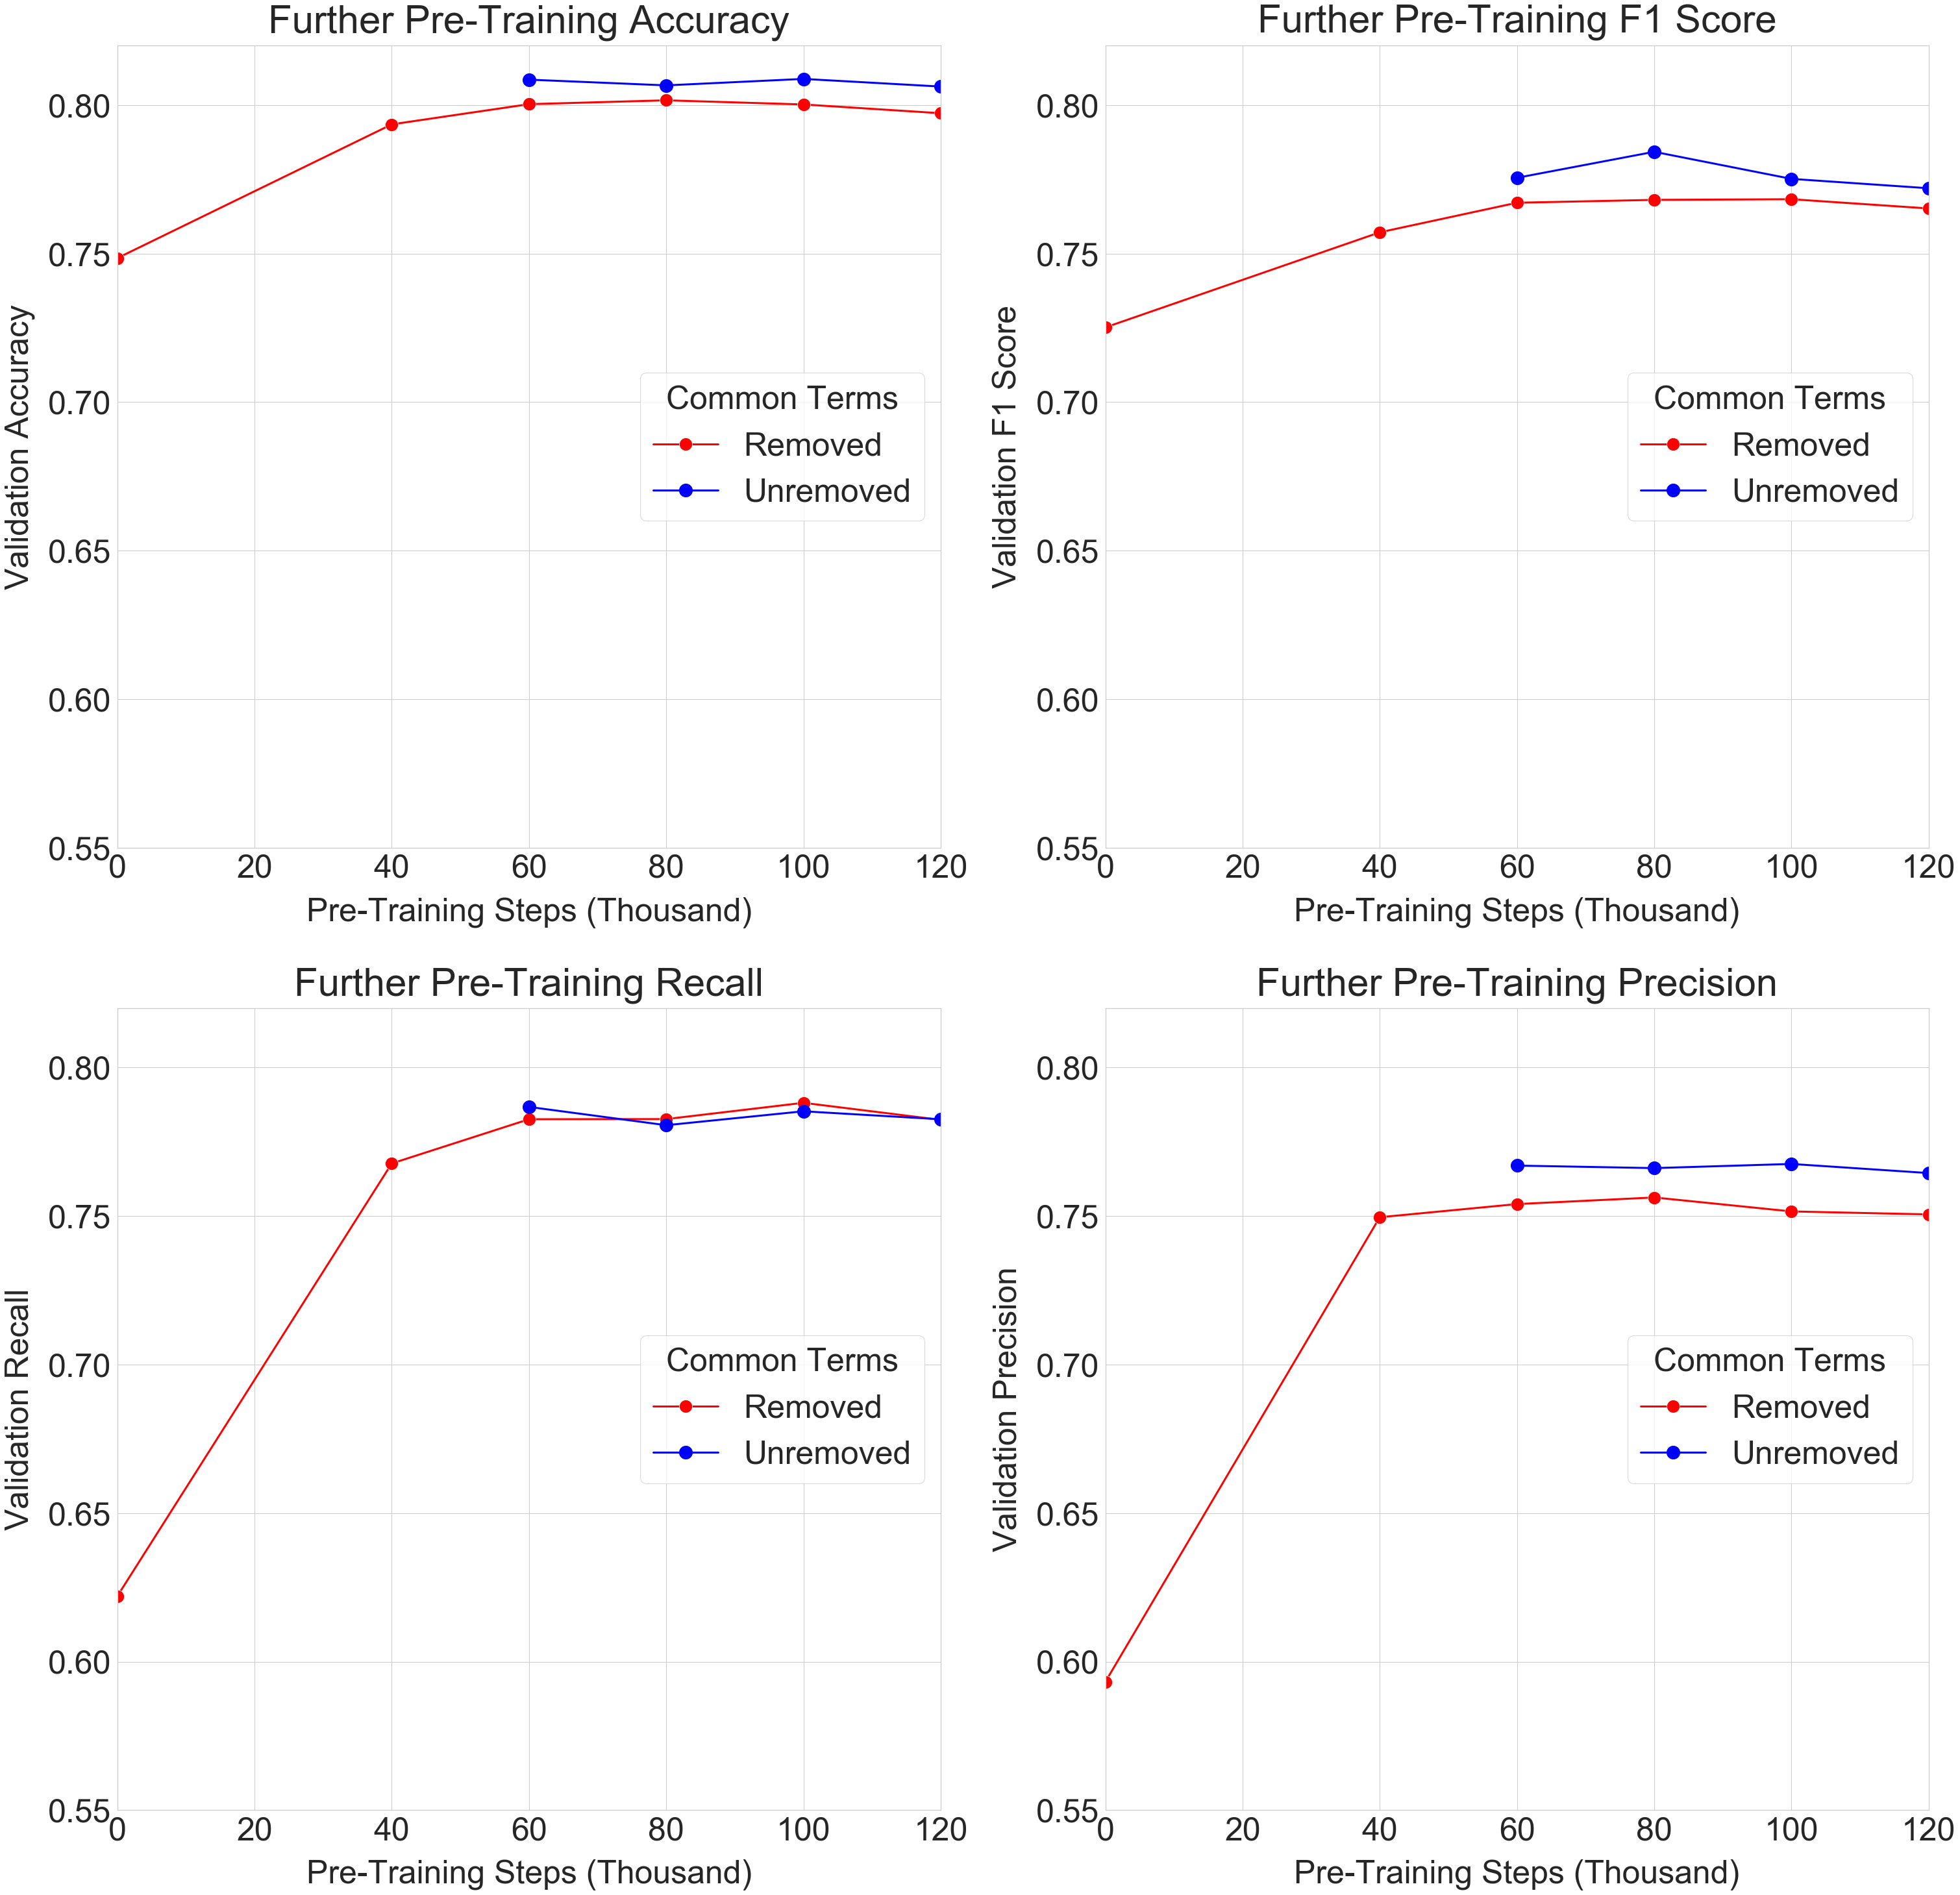

In [13]:
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = pretraindat1.index, y = metrics[i-1],\
                      data = pretraindat1, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    plt.ylim(0.55, 0.82)
    plt.xlim(0, 130)
    noRemTerms[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['Removed', 'Unremoved'], \
              title = 'Common Terms' ,prop = {'size': 50})

plt.show()

In [14]:
emoj = pd.read_csv('gs://csc3002/hateval2019/emojiReplacev2_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
emoj.index = [100, 80, 60]#,60,40, 0]
emoj.index = emoj.index.astype(int)
emoj

FileNotFoundError: 

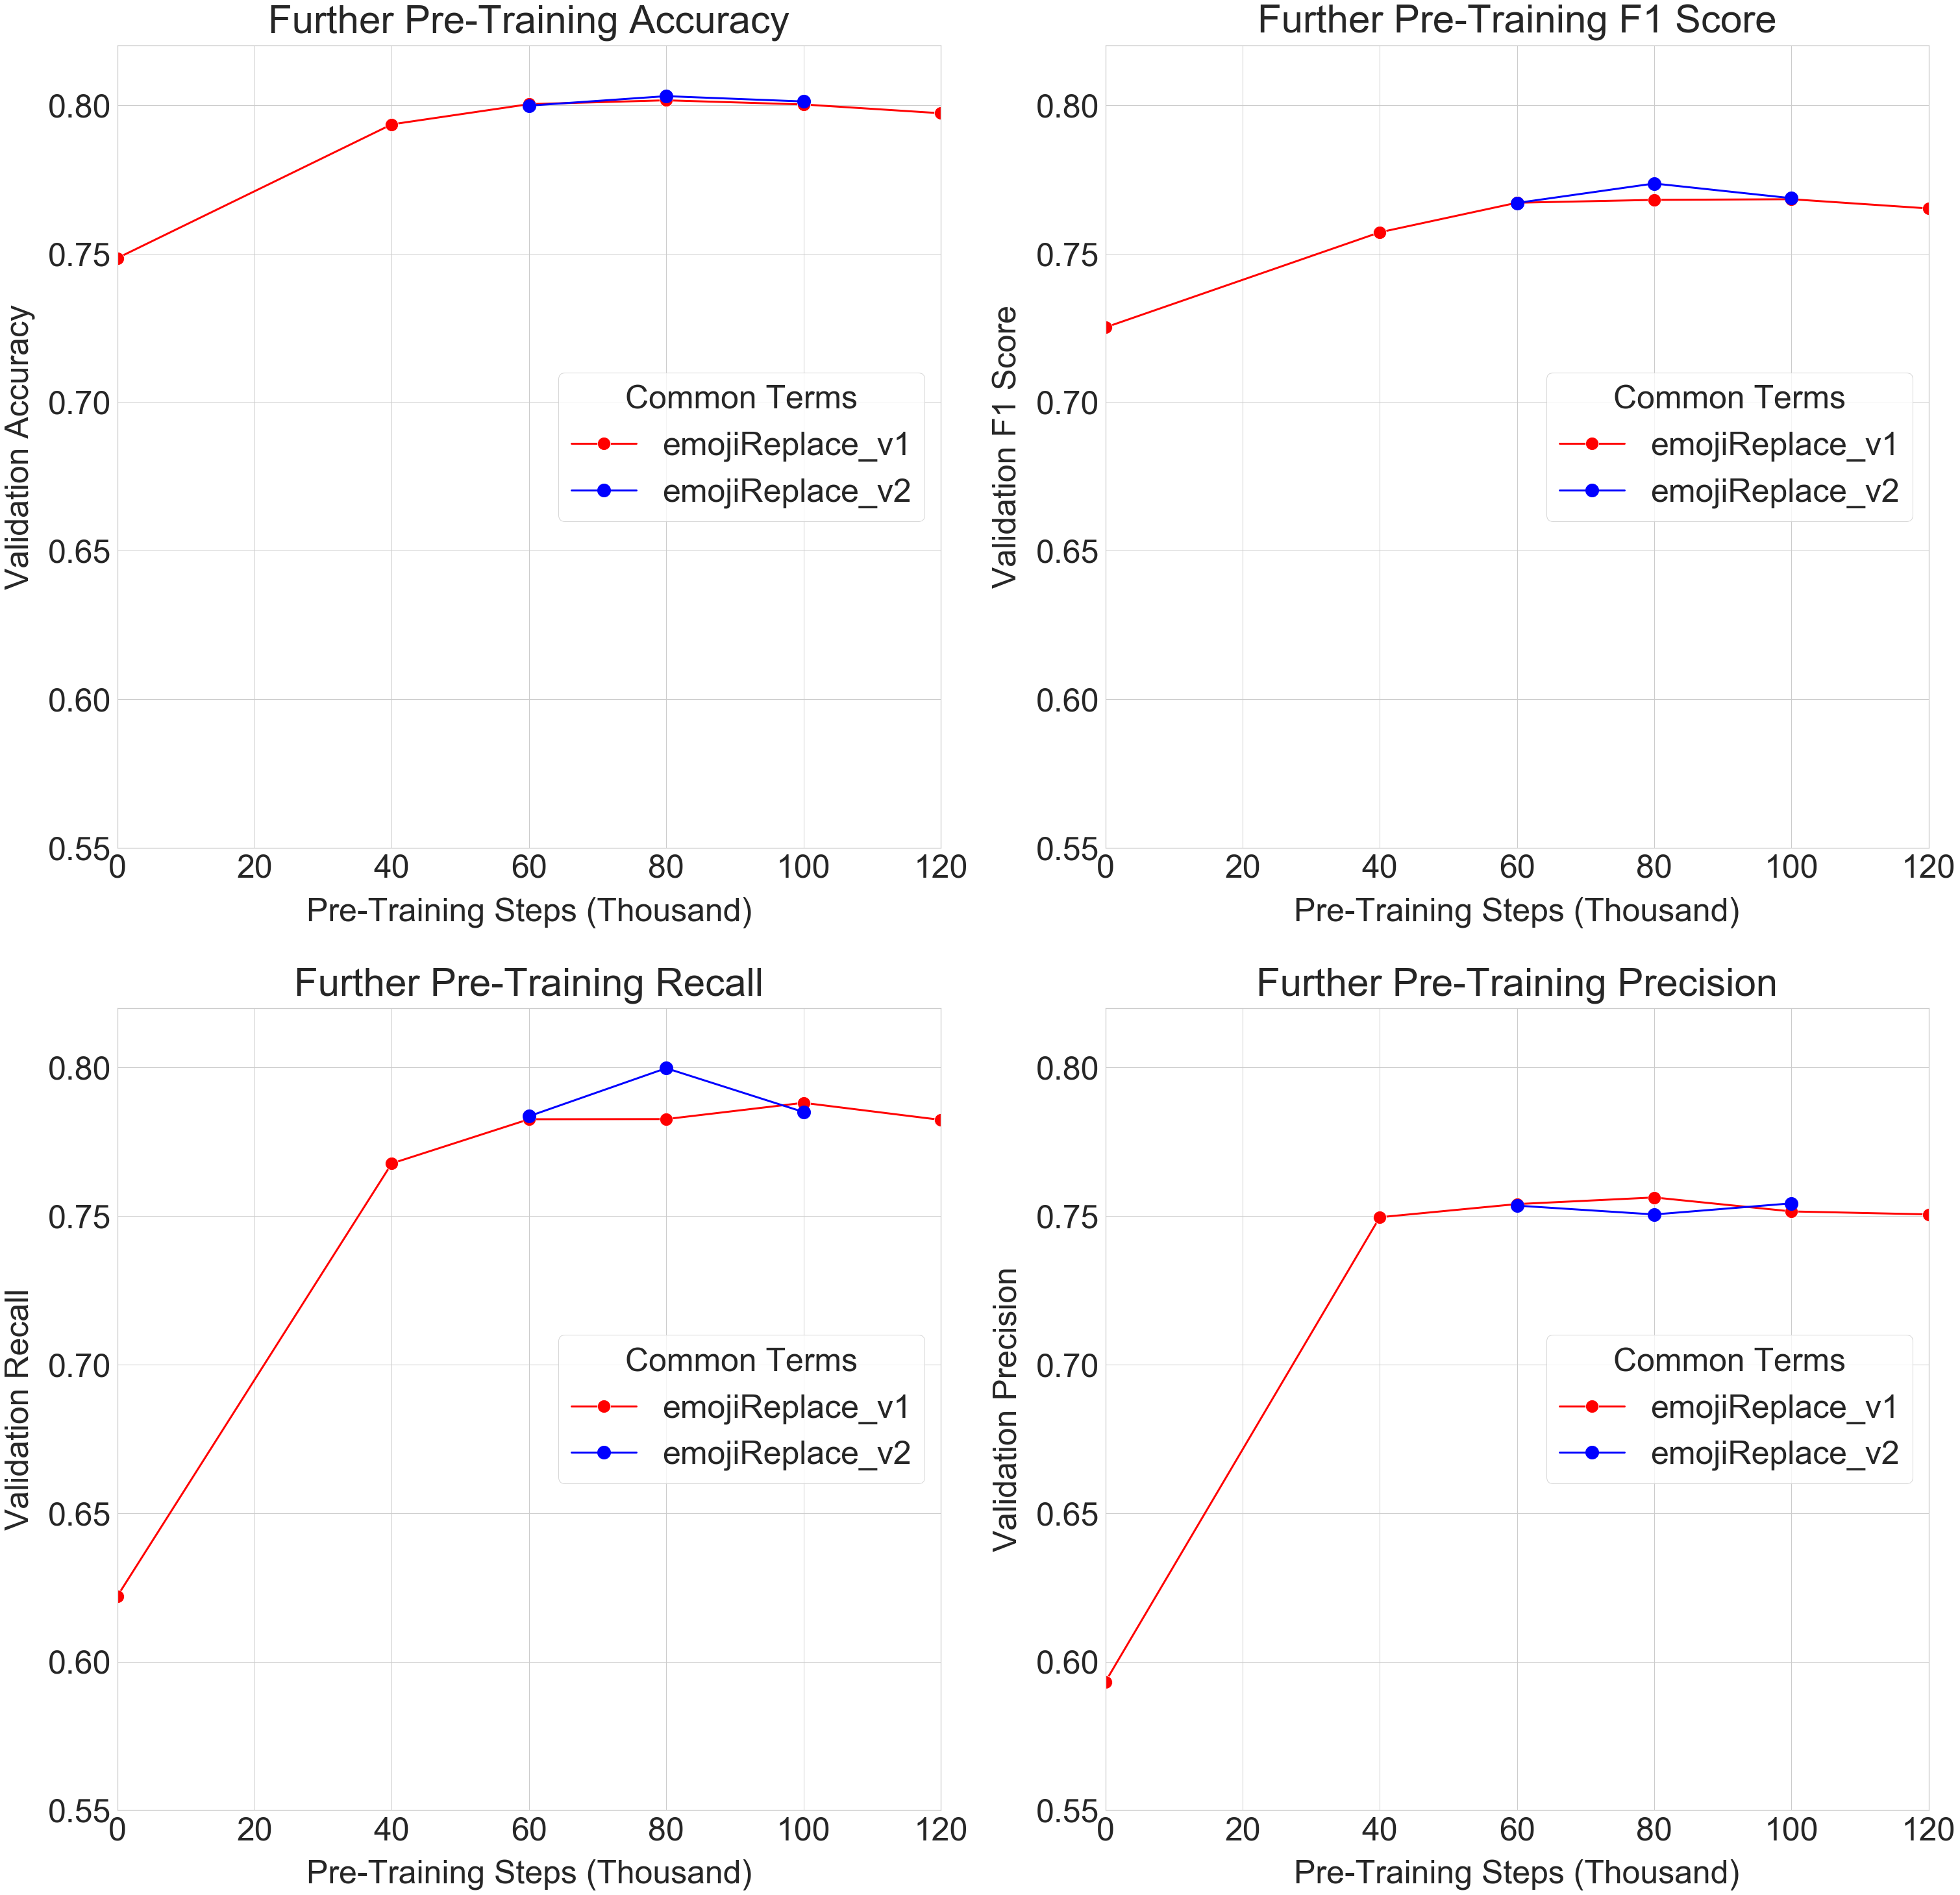

In [11]:
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = pretraindat1.index, y = metrics[i-1],\
                      data = pretraindat1, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    plt.ylim(0.55, 0.82)
    plt.xlim(0, 130)
    emoj[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['emojiReplace_v1', 'emojiReplace_v2'], \
              title = 'Common Terms' ,prop = {'size': 50})

plt.show()